In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedLocator

from scipy.ndimage.filters import gaussian_filter1d

In [2]:
%matplotlib notebook

In [34]:
ptf_df = pd.read_csv('../data/comp_sne/ptf_ia/Maguire_2014.tab5', 
                     delim_whitespace=True, skiprows=[0], header=None,
                     names = ['SN', 'phase', 'phase_err', 
                              'vsi4130', 'vsi4130_err', 'pewsi4130', 'pewsi4130_err', 
                              'vsi5972', 'vsi5972_err', 'pewsi5972', 'pewsi5972_err', 
                              'vsi6355', 'vsi6355_err', 'pewsi6355', 'pewsi6355_err', 
                              'vcair_pvf', 'vcair_pvf_err', 'pewcair_pvf', 'pewcair_pvf_err', 
                              'vcair_hvf', 'vcair_hvf_err', 'pewcair_hvf', 'pewcair_hvf_err'])

sn2002bo_df = pd.read_csv('../data/comp_sne/sn2002bo/v_pew_02bo.txt')

sn19yvq_df = pd.read_csv('../data/spectra/SN2019yvq_specanalysis.txt', delim_whitespace=True)
phases = pd.read_csv('../playground/spec_phase.txt', delim_whitespace=True)

In [7]:
data_dir = "/Users/adamamiller/astronomy/SN_Ia_models/ObsData/Blondin2012/"
ss_dat = pd.read_csv(data_dir + "vabsSiII6355_SS.csv")
cl_dat = pd.read_csv(data_dir + "vabsSiII6355_CL.csv")
cn_dat = pd.read_csv(data_dir + "vabsSiII6355_CN.csv")
bl_dat = pd.read_csv(data_dir + "vabsSiII6355_BL.csv")

## Make a dope figure

<IPython.core.display.Javascript object>


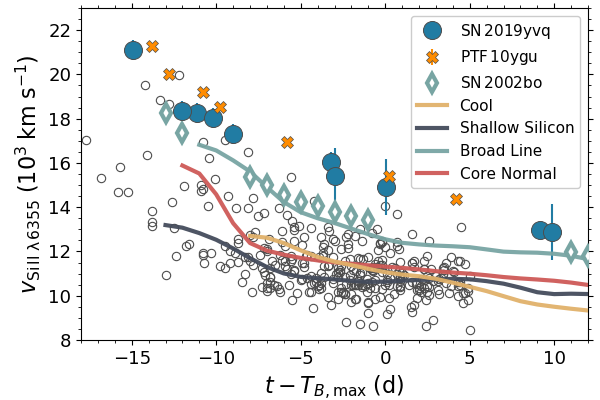

PTF09dnl
PTF10bjs
PTF10hdv
PTF10hml
PTF11bui


In [58]:
aam_colors = {'mustard': "#E29930",
             'blue': "#217CA3",
             'asphalt': "#32384D",
             'navy': "#444C5C",
             'punch': "#CE5A57",
             'ocean': "#78A5A3",
             'warm': "#E1B16A",}


fig, ax = plt.subplots(figsize=(6,4))

for index, row in ptf_df.iterrows():
    # similar velocity evolution: PTF10bjs, PTF10ygu
    if row.vsi6355 != '-' and index == 220:
        ax.errorbar(row.phase,
                    float(row.vsi6355)/1000, float(row.vsi6355_err)/1000,
                    fmt='X', color='DarkOrange', mec='0.3',mew=0.5, ms=8, 
                    zorder=15, label = r'$\mathrm{PTF\,10ygu}$')
    elif row.vsi6355 != '-' and row.SN == 'PTF10ygu':
        ax.errorbar(row.phase,
                    float(row.vsi6355)/1000, float(row.vsi6355_err)/1000,
                    fmt='X', color='DarkOrange', mec='0.3',mew=0.5, ms=8, 
                    zorder=15)
    elif row.vsi6355 != '-':
        ax.errorbar(row.phase,
                    float(row.vsi6355)/1000, float(row.vsi6355_err)/1000,
                    fmt='o', color='None', mec='0.3',mew=0.8)

        if row.phase < -10 and float(row.vsi6355) > 18000:
            print(row.SN)

t_grid = np.linspace(-20,40,61)
for branch_class, line_col, line_label in zip([cn_dat, bl_dat, ss_dat, cl_dat], 
                                              ["punch","ocean","navy","warm"],
                                              ["Core Normal", "Broad Line", 
                                               "Shallow Silicon", "Cool"]):
    sne = branch_class['SN'].unique()
    vel_arr = np.ma.empty((len(sne), len(t_grid)))
    for i_sn, sn in enumerate(sne):
        this_sn = np.where(branch_class["SN"] == sn)
        t_sn = branch_class["age"].iloc[this_sn]
        v_sn = branch_class["vabs"].iloc[this_sn]
        v_interp = np.interp(t_grid, t_sn, v_sn)
        vel_arr[i_sn] = v_interp
        vel_arr[i_sn] = np.ma.masked_where((t_grid < min(t_sn)) | (t_grid > max(t_sn)), vel_arr[i_sn])

    min_3_vels = np.where(np.ma.masked_array.count(vel_arr, axis = 0) >= 3)
    smooth_vel = gaussian_filter1d(np.ma.median(vel_arr, axis = 0)[min_3_vels].data, 
                                   sigma=1., mode='mirror')
    ax.plot(t_grid[min_3_vels], -1*smooth_vel,
            color = aam_colors[line_col], alpha = 0.95, lw = 3,
            label = line_label,
            zorder=10)

# plot SN2019yvq
for index, row in sn19yvq_df.iterrows():
    if row.vsi6355 != '-' and index == 0:
        ax.errorbar(phases.iloc[np.where(phases.specname == row.specname)].phase,
                    float(row.vsi6355)/1000, float(row.vsi6355_err)/1000,
                    fmt='o', color=aam_colors['blue'], mec='0.3',mew=0.7, ms=13,
                    zorder=10, label = r'$\mathrm{SN\,2019yvq}$')
    elif row.vsi6355 != '-':
        ax.errorbar(phases.iloc[np.where(phases.specname == row.specname)].phase,
                    float(row.vsi6355)/1000, float(row.vsi6355_err)/1000,
                    fmt='o', color=aam_colors['blue'], mec='0.3',mew=0.7, ms=13,
                    zorder=10)

# plot SN2002bo
ax.plot(sn2002bo_df.phase, sn2002bo_df.vsi6355/1000, 
        'd', color='white', mec=aam_colors['ocean'],mew=3, ms=9,
        zorder=10, label = r'$\mathrm{SN\,2002bo}$')

ax.set_ylim(8, 23)
ax.set_xlim(-18, 12)
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_minor_locator(MultipleLocator(0.5))
ax.set_ylabel(r"$v_\mathrm{Si\,II\;\lambda\,6355} \; (10^3 \;\mathrm{km\;s}^{-1})$", fontsize=16)
ax.set_xlabel(r"$t - T_{B,\mathrm{max}} \; (\mathrm{d})$", fontsize=16)
ax.tick_params(axis='both', which='both', top = True, right = True, labelsize=13)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper right', framealpha = 1, fontsize = 11)
fig.subplots_adjust(top = 0.98, bottom = 0.15, left = 0.135, right = 0.98)
fig.savefig('../paper/figures/vel_evolution.pdf')

<IPython.core.display.Javascript object>


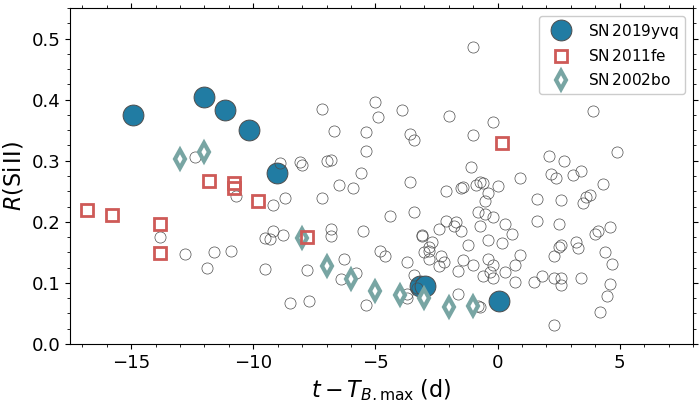

In [83]:
fig, ax = plt.subplots(figsize=(7,4))
for index, row in ptf_df.iterrows():
    # similar velocity evolution: PTF10bjs, PTF10ygu
    if row.pewsi6355 != '-' and row.pewsi5972 != '-' and row.SN != 'PTF11kly':
        _ = ax.errorbar(row.phase,
                    float(row.pewsi5972)/float(row.pewsi6355),
                    fmt='o', color='None', mec='0.3',mew=0.5, ms=8, 
                    zorder=15)
#     elif row.vsi6355 != '-' and row.SN == 'PTF10ygu':
#         ax.errorbar(row.phase,
#                     float(row.vsi6355)/1000, float(row.vsi6355_err)/1000,
#                     fmt='X', color='DarkOrange', mec='0.3',mew=0.5, ms=8, 
#                     zorder=15)
#     elif row.vsi6355 != '-':
#         ax.errorbar(row.phase,
#                     float(row.vsi6355)/1000, float(row.vsi6355_err)/1000,
#                     fmt='o', color='None', mec='0.3',mew=0.8)

#         if row.phase < -10 and float(row.vsi6355) > 18000:
#             print(row.SN)

for index, row in sn19yvq_df.iterrows():
    if row.pewsi6355 != '-' and row.pewsi5972 != '-' and index == 0:
        ax.errorbar(phases.iloc[np.where(phases.specname == row.specname)].phase,
                    float(row.pewsi5972)/float(row.pewsi6355),
                    fmt='o', color=aam_colors['blue'], mec='0.3',mew=0.7, ms=15,
                    zorder=10, label = r'$\mathrm{SN\,2019yvq}$')
    elif row.pewsi6355 != '-' and row.pewsi5972 != '-':
        ax.errorbar(phases.iloc[np.where(phases.specname == row.specname)].phase,
                    float(row.pewsi5972)/float(row.pewsi6355),
                    fmt='o', color=aam_colors['blue'], mec='0.3',mew=0.7, ms=15,
                    zorder=10)

# plot SN2002bo
ax.plot(sn2002bo_df.phase, sn2002bo_df.rpew_5972_6355, 
        'd', color='white', mec=aam_colors['ocean'],mew=3, ms=9,
        zorder=20, label = r'$\mathrm{SN\,2002bo}$')

        

this_sn = np.where((ptf_df.SN == 'PTF11kly') & 
                   (ptf_df.pewsi5972 != '-'))[0]
if len(this_sn) > 2:
    ax.plot(ptf_df.iloc[this_sn].phase,
            ptf_df.iloc[this_sn].pewsi5972.values.astype(float)/ptf_df.iloc[this_sn].pewsi6355.values.astype(float),
            's', color='None', mec=aam_colors['punch'],mew=2, ms=9,
            zorder=20, label = r'$\mathrm{SN\,2011fe}$')

ax.set_ylim(0,0.55)
ax.set_xlim(-17.5, 8)
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_minor_locator(MultipleLocator(0.025))
ax.set_ylabel(r"$R(\mathrm{Si}\,\mathrm{II})$", fontsize=16)
ax.set_xlabel(r"$t - T_{B,\mathrm{max}} \; (\mathrm{d})$", fontsize=16)
ax.tick_params(axis='both', which='both', top = True, right = True, labelsize=13)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], loc='upper right', framealpha = 1, fontsize = 11)

fig.subplots_adjust(top = 0.98, bottom = 0.14, left = 0.10, right = 0.99)
fig.savefig('../paper/figures/R_evolution.pdf')

In [27]:
ptf_df.iloc[this_sn].pewsi5972.values.astype(float)

array([7.3, 8.8, 5.2])

In [50]:
this_sn = np.where((ptf_df.SN == 'PTF11kly') & 
                       (ptf_df.pewsi5972 != '-'))[0]

ptf_df.iloc[this_sn].pewsi5972_err

289    0.2
290    0.4
291    0.4
292    0.5
293    0.4
294    0.5
295    0.3
296    0.2
297    0.3
298    1.9
Name: pewsi5972_err, dtype: object

In [86]:
sn19yvq_df[['vs5500','vsi6355']]

,vs5500,vsi6355
0,-,21107
1,15039,18264
2,-,18368
3,14959,18028
4,14346,17317
5,12794,16051
6,11961,15426
7,11073,14917
8,9965,-
9,-,12965
